In [1]:
from netgen.geom2d import SplineGeometry
from ngsolve import Mesh
import matplotlib.pyplot as plt
import numpy as np

In [2]:
R = 10.
H = 1.



geo = SplineGeometry()
geo.AddRectangle(p1=(-R,-H),
                 p2=( R, H),
                 bcs=["Gamma","Sigma_p","Gamma","Sigma_n"],
                 leftdomain=1,
                 rightdomain=0)
geo.AddCircle(c=(0,0),
              r=0.4,
              bc="dOmega",
              leftdomain=2,
              rightdomain=1)
geo.SetMaterial (1, "Omega_e")
geo.SetMaterial (2, "Omega_i")

In [3]:
ngmesh = geo.GenerateMesh(maxh=2.)
Omega = Mesh(ngmesh)

In [4]:
Interior = Omega.Materials('Omega_e | Omega_i')

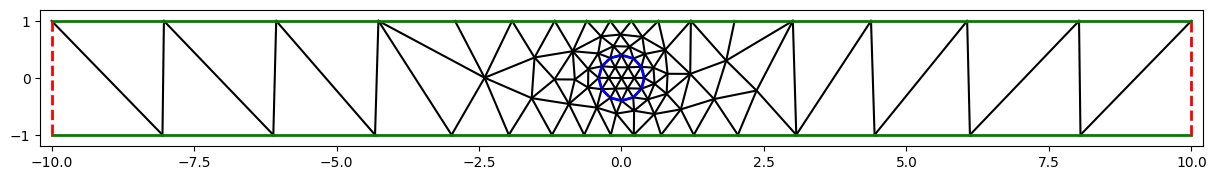

In [5]:
def plot_mesh( M : Mesh, ax : plt.Axes | None = None): 
    """Plots a mesh"""
    points = np.fromiter( (v.point for v in M.vertices), dtype=np.dtype((float, 2)), count=M.nv)
    
    if ax is None:
        _, ax = plt.subplots( figsize=(15,3))
    for l in M.edges:
        if len(l.elements) == 2:
            px, py = points[l.vertices[0].nr]
            qx, qy = points[l.vertices[1].nr]
            ax.plot( [px, qx], [py, qy], 'k')

    lw = 2

    for e in M.Boundaries("Gamma").Elements():
        px, py = points[e.vertices[0].nr]
        qx, qy = points[e.vertices[1].nr]
        ax.plot( [px, qx], [py, qy], 'g', linewidth=lw)

    for e in M.Boundaries("Sigma_p").Elements():
        px, py = points[e.vertices[0].nr]
        qx, qy = points[e.vertices[1].nr]
        ax.plot( [px, qx], [py, qy], '--r', linewidth=lw)

    for e in M.Boundaries("Sigma_n").Elements():
        px, py = points[e.vertices[0].nr]
        qx, qy = points[e.vertices[1].nr]
        ax.plot( [px, qx], [py, qy], '--r', linewidth=lw)


    for e in M.Boundaries("dOmega").Elements():
        px, py = points[e.vertices[0].nr]
        qx, qy = points[e.vertices[1].nr]
        ax.plot( [px, qx], [py, qy], '--b', linewidth=lw)


    #ax.scatter(x=points[:,0], y=points[:,1])
    d = 0.2
    ax.axis('square')
    ax.set_xlim([-R-d,R+d])
    ax.set_ylim([-H-d,H+d])


plot_mesh(Omega)


Lets check for counter clockwise-ness

In [6]:
# def cross_product(ux, uy, vx, vy):
#     cp = ux*vy - uy*vx
#     return cp

# vertices = list(Omega.vertices)

# triangles = list(Omega.faces)

# def is_counterclockwise(K):
#     px, py = vertices[K.vertices[0].nr].point
#     qx, qy = vertices[K.vertices[1].nr].point
#     rx, ry = vertices[K.vertices[2].nr].point
#     ux = qx - px
#     uy = qy - py 
#     vx = rx - px 
#     vy = ry - py
#     cp = cross_product(ux,uy,vx,vy)
#     return cp > 0

# for K in triangles:
#     print(is_counterclockwise(K))

    

False
True
False
True
False
True
True
False
False
True
True
False
False
True
True
True
False
False
True
True
False
True
False
False
True
True
True
True
True
True
True
True
False
True
True
True
False
True
True
True
False
True
True
True
True
False
True
False
True
False
True
True
True
True
True
True
True
True
True
True
True
False
True
True
False
True
True
True
False
True
False
True
False
True
True
True
False
True
True
True
False
False
True
True
False
True
False
True
False
True
False
False
True
False
False
True
False
True
False
True
True
False
False
True
True
False
True
False
True
False
False
True
False
True
True
True
False
False
True
False
False
False
False
False
False
False
True
True
True
False
True
True
True
True


I think its easier if we force it to be counter-clockwise

In [7]:
# cc_triangles = []
# for K in triangles:
#     if is_counterclockwise(K):
#         cc_triangles.append(K.vertices)
#     else:
#         cc_triangles.append((K.vertices[1],K.vertices[0],K.vertices[2]))

In [8]:
def is_counterclockwise(K):
    px, py = vertices[K[0].nr].point
    qx, qy = vertices[K[1].nr].point
    rx, ry = vertices[K[2].nr].point
    ux = qx - px
    uy = qy - py 
    vx = rx - px 
    vy = ry - py
    cp = cross_product(ux,uy,vx,vy)
    return cp > 0


for K in cc_triangles:
    print(is_counterclockwise(K))


True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True


I will create three arrays, one which indicates the number of plane waves per element, another one with the coefficients and another one with their ownership.

In [9]:
class TrefftzFun:
    def __init__( self, Omega : Mesh, Np : list[int], kappa : list[float]):
        assert Omega.ne == len(Np)
        self.Ncoef = sum(Np) 
        self.Np = Np
        self.coefs = np.zeros(self.Ncoef, dtype=np.complex128)
        #self.index = np.zeros(self.Ncoef, dtype=np.int32)
        self.kappa = kappa
        #i=0
        #for e in range(Omega.ne):
        #    self.index[i:i+Np[e]] = e
        #    i=i+Np[e]

        self.e_to_coef = np.zeros( (Omega.ne,2), dtype=np.int32)
        i = 0
        for e in range(Omega.ne):
            self.e_to_coef[e,:] = np.array( i, Np[e])
            i += Np[e]
    

    def set_coeffs( self, coeffs):
        self.coefs = coeffs


    def __call__(self, x, y ):
        e_ID = Omega(x,y).nr
        k = self.kappa[e_ID]
        id0 = self.e_to_coef[e_ID,0]
        y = sum( [self.coefs[id0+n] * np.exp(1j*k*(x*np.cos(th) + y*np.sin(th))) 
                  for (n,th) in enumerate(np.linspace(0,2*np.pi, self.Np[e_ID], endpoint=False))] )
        return y 



In [10]:
Nth = 3
Np = np.full(Omega.ne, Nth, dtype=np.int32) #homogeneous number of plane waves
k_in = 70
k_out = 7
kappa = [ k_out if e.mat == "Omega_e" else k_in for e in Omega.Elements()]
f = TrefftzFun(Omega, Np, kappa)

In [11]:
#f.set_coeffs(np.tile([1,0],Omega.ne))
coeffs = np.random.randint(10,size=Nth*Omega.ne)
#coeffs = np.random.uniform(-1, 1, Nth*Omega.ne) + 1.j * np.random.uniform(-1, 1, Nth*Omega.ne)

f.set_coeffs(coeffs)

In [12]:
Ny = 50
Nx = 10*Ny
x = np.linspace(-R,R,Nx)
y = np.linspace(-H,H,Ny)
X, Y = np.meshgrid(x,y)

Z =  np.reshape([ f(x_, y_) for x_, y_ in zip( X.ravel(), Y.ravel()) ], [Ny,Nx])



(-1.0, 1.0)

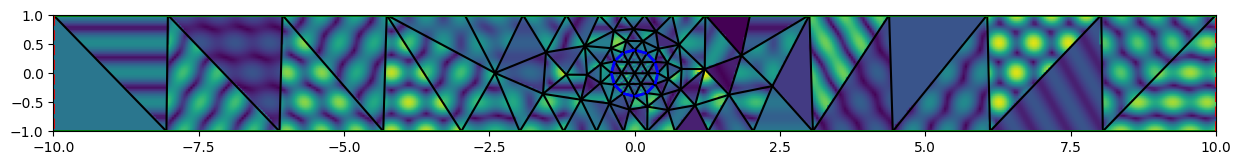

In [13]:
_, ax = plt.subplots( figsize=(15,3))
ax.imshow(np.abs(Z), origin="lower", extent=[-R,R,-H,H])
plot_mesh(Omega, ax)
ax.axis('square')
ax.set_xlim([-R,R])
ax.set_ylim([-H,H])


(-1.0, 1.0)

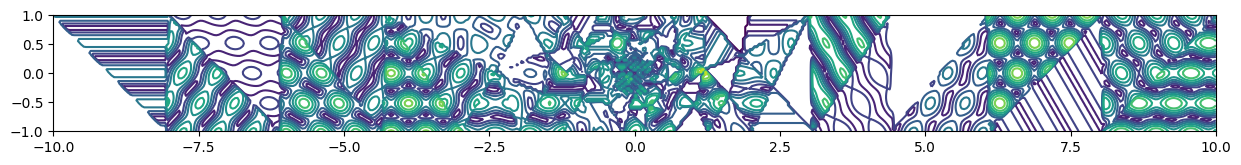

In [14]:
_, ax = plt.subplots( figsize=(15,3))
ax.contour(X,Y,np.abs(Z),10)
ax.axis('square')
ax.set_xlim([-R,R])
ax.set_ylim([-H,H])


# Naive Implementation:

This implementation should not be stable

In [15]:
N_elements = Omega.ne
NP = np.sum(Np)


A = np.zeros((NP,NP), dtype=np.complex128)
b = np.zeros((NP), dtype=np.complex128)

In [18]:
Vertices = np.array([ list(v.point) for v in Omega.vertices])
Edges = np.array([ [e.vertices[0].nr, e.vertices[1].nr]  for e in Omega.edges])
MidPoints = np.array([ (Vertices[e[0]] + Vertices[e[1]])/2 for e in Edges] )
Triangles = list(Omega.facets)

def getNormal(p,q):
    px, py = p
    qx, qy = q
    tx, ty = q - p

    if py == qy == H:
        return [ 0.,  1.]
    if py == qy == -H:
        return [ 0., -1]
    if px == qx == R:
        return [ 1., 0.]
    if py == qy == -R:
        return [ -1., 0.]

    N = [ -ty, tx] / np.sqrt(tx**2 + ty**2)
    return N

Normals = np.array( [ getNormal(Vertices[e[0]],Vertices[e[1]]) for e in Edges])

(-2.0, 2.0)

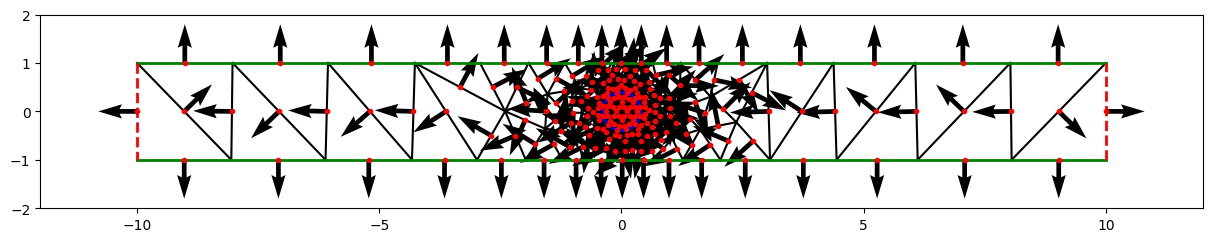

In [17]:
plot_mesh(Omega)
plt.plot(MidPoints[:,0],MidPoints[:,1],'.r')
plt.quiver(MidPoints[:,0],MidPoints[:,1],Normals[:,0],Normals[:,1], scale=30)
plt.xlim([-12,12])
plt.ylim([-2,2])

In [20]:
class Edge:
    '''Holds all the information from an edge that is needed:
    - P : inital vertex
    - Q : end point
    - N : normal
    - PQ : vector PQ
    - lenght : norm of PQ'''
    def __init__(self, P, Q, N ):
        self.P = P
        self.Q = Q
        self.N = N 
        self.PQ = Q - P
        self.lenght = norm(self.PQ)
        

In [19]:
from numpy import dot, exp
from numpy.linalg import norm

def Gamma_term(phi, psi, edge):
    kd_n = phi.k * phi.d
    kd_m = psi.k * psi.d
    kd_mn = kd_n - kd_m
    
    N = edge.N
    P = edge.P 
    Q = edge.Q 
    ell = edge.PQ
    l = edge.lenght 

    I = dot(kd_m, N) * l / dot( kd_mn, ell) *( exp(1j*dot(kd_mn,P)) - exp(1j*dot(kd_mn,Q)) )
    return I 




In [ ]:
class FiniteTrefftzSpace:
    '''allows the creation of test and trial functions, at least'''
    def __init__(self, Omega, local_degrees : tuple[int], kappa : tuple[float]):
        self.local_degrees = local_degrees
        self.kappa = kappa
    
    def TestFunction(self, n )

